In [3]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import re
from unidecode import unidecode
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

def normalize_column_name(col):
    col = re.sub('(\n|\t)', '', col) # replace \n and \t with ''
    col = col.lower() # lower
    col = re.sub(' ', '_', col) # repace ' ' with '_'
    col = re.sub('-', '_', col) # repace ' ' with '_'
    col = unidecode(col) # remove accent
    return col

def del_column(df, col_list):
    rem = [i for i in df.columns if i not in col_list]
    df = df[rem]
    return df

# 1. Load & Cleaning data

In [5]:
l = pd.read_html('https://en.wikipedia.org/wiki/List_of_English_football_champions')
df = l[2]
df.columns = [normalize_column_name(i[0]) for i in df.columns]

df = (
    df
    .rename({'champions_(number_of_titles)': 'champion'}, axis = 1)
    .loc[:,['season', 'champion', 'runners_up', 'third_place']]
)

df = df[~ ((df['champion'].str.contains('War')) | (df['season'].str.contains(r'\('))) ]

df = (
    df
    .assign(champion =              lambda df_: df_['champion'].str.extract(r'(^[\w\s]+)')[0].str.strip())
    .assign(runners_up =            lambda df_: df_['runners_up'].str.extract(r'(^[\w\s]+)')[0].str.strip())
    .replace('The Wednesday', 'Sheffield Wednesday')
)
df

,season,champion,runners_up,third_place
0,1888–89,Preston North End,Aston Villa,Wolverhampton Wanderers
1,1889–90,Preston North End,Everton,Blackburn Rovers
2,1890–91,Everton,Preston North End,Notts County
3,1891–92,Sunderland,Preston North End,Bolton Wanderers
5,1892–93,Sunderland,Preston North End,Everton
...,...,...,...,...
125,2020–21,Manchester City,Manchester United,Liverpool
126,2021–22,Manchester City,Liverpool,Chelsea
127,2022–23,Manchester City,Arsenal,Manchester United
128,2023–24,Manchester City,Arsenal,Liverpool


# 2. Pre-processing

In [6]:
def add_season_year(df):
    df = (
        df
        .assign(season_start =          lambda df_: df_.season.apply(lambda x: int(x[:4])))
        .assign(season_end =            lambda df_: df_.season_start + 1)
        .sort_values(by = ['champion', 'season_end'], ignore_index=True)
        .assign(next_win =              lambda df_: df_.groupby('champion')['season_end'].shift(-1))
        .assign(gap =                   lambda df_: df_['next_win'] - df_['season_end'])
    )

    return df

### 2.1. Detect and label the consecutive titles

In [ ]:
def detect_label_consecutive(df):
    df = df.sort_values('season_end').reset_index(drop=True)
    df['lientiep_group'] = (df.season_end.diff() != 1).cumsum()

    df['lientiep_label'] = (
        df.lientiep_group
        .map(df.groupby('lientiep_group')
        .season_end.count()).apply(lambda x: str(x) + ' consecutive titles' if x > 1 else '')
    )
    
    return df.drop(columns= ['lientiep_group'])

def add_label_consecutive(df):
    df = df.groupby('champion', group_keys=False).apply(detect_label_consecutive).sort_values(by = 'season', ignore_index= True)
    return df

C:\Users\minhtl3\AppData\Local\Temp\ipykernel_12156\1783128086.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('champion', group_keys=False).apply(label_consecutive).sort_values(by = 'season', ignore_index= True)


,season,champion,runners_up,third_place,season_start,season_end,next_win,gap,lientiep_label
0,1888–89,Preston North End,Aston Villa,Wolverhampton Wanderers,1888,1889,1890.0,1.0,2 consecutive titles
1,1889–90,Preston North End,Everton,Blackburn Rovers,1889,1890,NaN,NaN,2 consecutive titles
2,1890–91,Everton,Preston North End,Notts County,1890,1891,1915.0,24.0,
3,1891–92,Sunderland,Preston North End,Bolton Wanderers,1891,1892,1893.0,1.0,2 consecutive titles
4,1892–93,Sunderland,Preston North End,Everton,1892,1893,1895.0,2.0,2 consecutive titles
...,...,...,...,...,...,...,...,...,...
121,2020–21,Manchester City,Manchester United,Liverpool,2020,2021,2022.0,1.0,4 consecutive titles
122,2021–22,Manchester City,Liverpool,Chelsea,2021,2022,2023.0,1.0,4 consecutive titles
123,2022–23,Manchester City,Arsenal,Manchester United,2022,2023,2024.0,1.0,4 consecutive titles
124,2023–24,Manchester City,Arsenal,Liverpool,2023,2024,NaN,NaN,4 consecutive titles


### 2.2. Detect and label the largest gap between titles of a team

In [80]:
# largest_gap = df[df.gap > 1].groupby('champion')['gap'].max()
# df['largest_gap'] = df.apply(lambda row: "largest_gap" if row['gap'] == largest_gap.get(row['champion'], -1) else "", axis = 1)
# largest_gap_df = df[df.largest_gap == 'largest_gap'].drop_duplicates(subset='champion', keep='last')

In [7]:
# largest_gap
def detect_largest_gap(df):
    largest_gap = df[df.gap > 1].groupby('champion').gap.max()
    df['largest_gap'] = df.apply(lambda df_: "largest_gap" if df_['gap'] == largest_gap.get(df_['champion'], -1) else "", axis=1)
    largest_gap_df = df[df.largest_gap == 'largest_gap'].drop_duplicates(subset = 'champion', keep='last')
    
    return largest_gap_df

# 3. Analysis

### **Who were the winners?**

In [82]:
df.champion.nunique()

24

### **Who got the most titles?**

In [8]:
def visualize_number_of_titles(df):
    fig, ax = plt.subplots(figsize = (10,8))

    champion_value_count = df.champion.value_counts()
    num_champion = len(champion_value_count)

    barplot = sns.barplot(
        champion_value_count
        ,orient= 'h'
        ,ax=ax
    )

    ax.set_title('Number of titles in English first division & EPL history')
    ax.set_ylabel('Teams')
    ax.set_xlabel('Number of titles')
    plt.xticks(range(1,champion_value_count.max()+1))

    for bar in barplot.containers:
        ax.bar_label(bar, padding = 5, label_type= "edge")
        ax.bar

    plt.show()


### **When did they get the titles?**

AttributeError: 'DataFrame' object has no attribute 'lientiep_label'

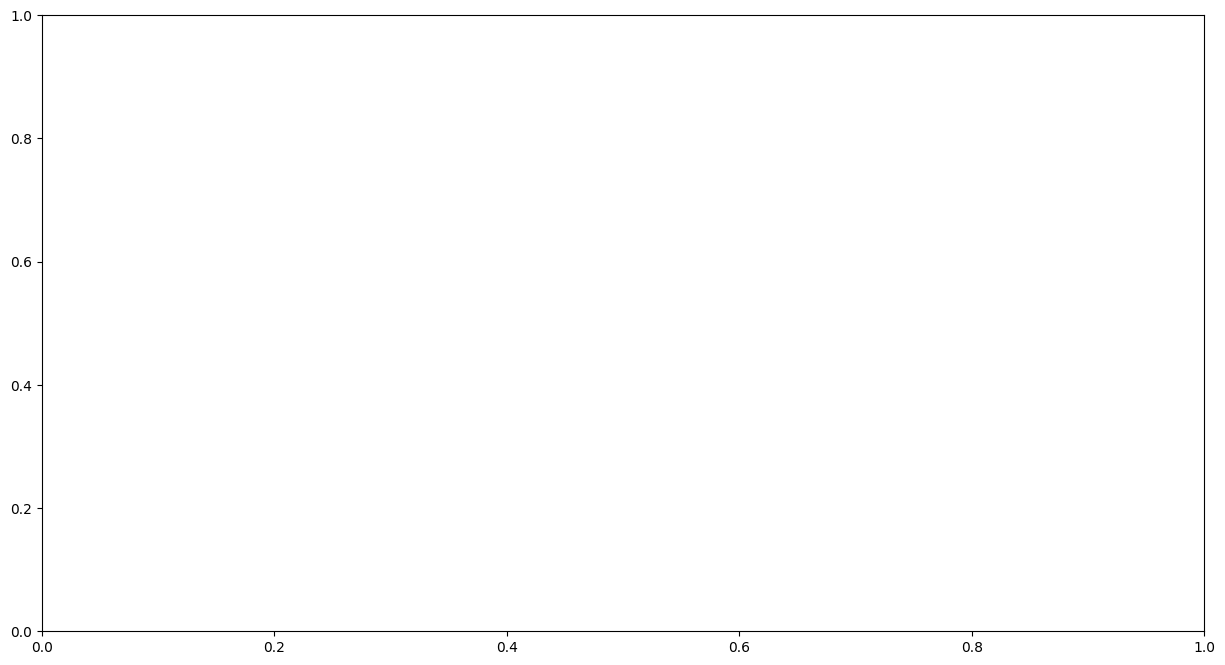

In [9]:
fig, ax = plt.subplots(figsize = (15,8))
min_x = 1880
max_x = 2030

champion_value_count = df.champion.value_counts()

lientiep_color_dict = {
    '4 consecutive titles': '#A4303F'
    ,'3 consecutive titles': '#379634'
    ,'2 consecutive titles': '#F5B841'
    ,'': '#84BCDA'
}

df['lientiep_color'] = df.lientiep_label.map(lientiep_color_dict)

sns.stripplot(
    data = df
    ,x = 'season_end'
    ,y = 'champion'
    ,jitter=False
    ,order= champion_value_count.index
    ,ax=ax
    ,hue= 'lientiep_label'
    ,palette= lientiep_color_dict
)

for i, (index, row) in enumerate(largest_gap_df.iterrows()):
    plt.plot([row['season_end'], row['next_win']], [row['champion'], row['champion']], color = 'grey')
    plt.text(
        x = (row['season_end'] + row['next_win'])/2
        , y = row['champion'], s = str(int(row['gap'])) + ' years'
        , fontsize = 9
        , ha = 'center'
        , va = 'bottom'
        , style = 'italic'
    )

ax.legend(title = 'Num of consecutive titles')
ax.set_title('History of English First Division & EPL Winners', fontweight = 'bold', fontsize = 14, y = 1.03)
ax.text(0.5, 1, "and the longest periods between two titles",
        ha="center", va="bottom", transform=ax.transAxes, fontsize=12, color="gray")

ax.set_xlabel('Years')
ax.set_ylabel('Teams')
ax.set_xlim((min_x, max_x))
ax.set_xticks(range(min_x, max_x, 10))

plt.grid(axis="y", color="grey", linestyle="--", alpha=0.7)
plt.grid(axis="x", color="grey", linestyle="--", alpha=0.7)

for i, val in enumerate(champion_value_count):
    plt.text(x = min_x+1, y = champion_value_count.index[i], s = str(val), va = 'center')

ax.annotate(
    arrowprops=dict(arrowstyle = "->")
    ,text = ""
    ,xy = (1,1)
)

plt.text(min_x + 2, y = -1.5, s = "Number of titles", ha = "center", fontsize = 8, color = "gray")

plt.show()

# Laliga

In [130]:
laliga_html = pd.read_html('https://en.wikipedia.org/wiki/List_of_Spanish_football_champions')
laliga = laliga_html[2]
laliga


laliga.columns = [normalize_column_name(i) for i in laliga.columns]

# laliga = (
#     laliga
#     .rename({'champions_(number_of_titles)': 'champion'}, axis = 1)
#     .loc[:,['season', 'champion', 'runners_up', 'third_place']]
# )

# laliga = laliga[~ ((laliga['champion'].str.contains('War')) | (laliga['season'].str.contains(r'\('))) ]

# laliga = (
#     laliga
#     .assign(champion =              lambda df_: df_['champion'].str.extract(r'(^[\w\s]+)')[0].str.strip())
#     .assign(runners_up =            lambda df_: df_['runners_up'].str.extract(r'(^[\w\s]+)')[0].str.strip())
#     .assign(season_start =          lambda df_: df_.season.apply(lambda x: int(x[:4])))
#     .assign(season_end =            lambda df_: df_.season_start + 1)
#     .sort_values(by = ['champion', 'season_end'], ignore_index=True)
#     .assign(next_win =              lambda df_: df_.groupby('champion')['season_end'].shift(-1))
#     .assign(gap =                   lambda df_: df_['next_win'] - df_['season_end'])
#     .replace('The Wednesday', 'Sheffield Wednesday')
# )
laliga

,season,winners[3],pts,runners_up[6][7],pts.1,third_place[6][7],pts.2,top_scorer(s)[8],top_scorer's_club(s)[8],goals[8]
0,1929,Barcelona (1),25,Real Madrid (1),23,Athletic Bilbao (1),20,Paco Bienzobas,Real Sociedad,14
1,1929–30,Athletic Bilbao (1) †,30,Barcelona (1),23,Arenas (1),20,Guillermo Gorostiza,Athletic Bilbao,19
2,1930–31,Athletic Bilbao (2) †,22,Racing Santander (1),22,Real Sociedad (1),22,Bata,Athletic Bilbao,27
3,1931–32,Madrid FC[a] (1),28,Athletic Bilbao (1),25,Barcelona (1),24,Guillermo Gorostiza,Athletic Bilbao,12
4,1932–33,Madrid FC[a] (2),28,Athletic Bilbao (2),26,Espanyol (1),22,Manuel Olivares,Madrid FC,16
5,1933–34,Athletic Bilbao (3),24,Madrid FC (2),22,Racing Santander (1),19,Isidro Lángara,Oviedo,27
6,1934–35,Real Betis (1),34,Madrid FC (3),33,Oviedo (1),26,Isidro Lángara,Oviedo,26
7,1935–36,Athletic Bilbao (4),31,Madrid FC (4),29,Oviedo (2),28,Isidro Lángara,Oviedo,27
8,1936–37,League suspended due to Spanish Civil War,League suspended due to Spanish Civil War,League suspended due to Spanish Civil War,League suspended due to Spanish Civil War,League suspended due to Spanish Civil War,League suspended due to Spanish Civil War,League suspended due to Spanish Civil War,League suspended due to Spanish Civil War,League suspended due to Spanish Civil War
9,1937–38,League suspended due to Spanish Civil War,League suspended due to Spanish Civil War,League suspended due to Spanish Civil War,League suspended due to Spanish Civil War,League suspended due to Spanish Civil War,League suspended due to Spanish Civil War,League suspended due to Spanish Civil War,League suspended due to Spanish Civil War,League suspended due to Spanish Civil War
